In [ ]:
## langgraph simple chat works! but not add tools

In [2]:
!pip install -U langgraph langsmith langchain_anthropic

  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.1.132
    Uninstalling langsmith-0.1.132:
      Successfully uninstalled langsmith-0.1.132
  Attempting uninstall: anthropic
    Found existing installation: anthropic 0.35.0
    Uninstalling anthropic-0.35.0:
      Successfully uninstalled anthropic-0.35.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
embedchain 0.1.125 requires langsmith<0.2.0,>=0.1.17, but you have langsmith 0.2.10 which is incompatible.
open-webui 0.3.32 requires chromadb==0.5.9, but you have chromadb 0.5.20 which is incompatible.
open-webui 0.3.32 requires einops==0.8.0, but you have einops 0.4.1 which is incompatible.
open-webui 0.3.32 requires flask==3.0.3, but you have flask 3.0.0 which is incompatible.
open-webui 0.3.32 requires langchain==0.2.15, but you have langchain 0.3.13 which is incompatible.
open-webui 0.3.32 requires langchain-community==0.2.12, but you have langchain-community 0.3.13 which is incompatible.
open-webui 0.3.32 requires pandas==2.2.3, but you have pandas 2.1.4 which is incompatible.
open-webui 0.3.32 requires pypdf==4.3.1, but you have pypdf 5.1.0 which is incompatible.


In [ ]:
import os
API_KEY = '<OPENAI_API_KEY>'
Deepseek_key='<OPENAI_API_KEY>'
Tav_API_KEY='<TAVILY_API_KEY>'
os.environ['OPENAI_API_KEY']=API_KEY
os.environ["TAVILY_API_KEY"]=Tav_API_KEY
#os.environ["TAVILY_API_KEY"] = "your_api_key_here"

In [ ]:
from langchain import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from langchain.agents import initialize_agent, Tool
from langchain.tools import BaseTool
import json
import pandas as pd
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [68]:
from langchain_community.tools.tavily_search import TavilySearchResults
tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Feb 14, 2024 ... Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step . You define nodes to perform'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': 'Jun 26, 2024 ... Imagine your application as a directed graph. In LangGraph, each node represents an LLM agent, and the edges are the communication channels'}]

In [69]:
## https://github.com/langchain-ai/langchain/issues/21479
### LLM with tool
llm = ChatOpenAI(
    api_key= API_KEY,
    temperature = 0,
    model_name = 'gpt-4o'
)

#llm_with_tools = llm.bind_tools(tools) 

In [70]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


#llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
# Modification: tell the LLM which tools it can call
#llm_with_tools = llm.bind_tools(tools)

conversational_agent = initialize_agent(
agent = 'chat-conversational-react-description',
tools = tools,
llm = llm,
verbose = True,
max_iterations = 100,
early_stopping_method = 'generate',
#memory = memory
)


#def chatbot(state: State):
    #return {"messages": [llm_with_tools.invoke(state["messages"])]}
    #return {"messages": [conversational_agent.invoke(state["messages"])]}


#graph_builder.add_node("chatbot", chatbot)

In [71]:
#def chatbot(state: State):
#    return {"messages": [llm_with_tools.invoke(state["messages"])]}
#graph_builder.add_node("chatbot", chatbot)

In [72]:
from langchain_anthropic import ChatAnthropic

#llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [73]:
graph_builder.add_node("chatbot", chatbot)

ValueError: Node `chatbot` already present.

In [74]:
graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

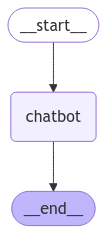

In [75]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  what model


Assistant: Could you please provide more context or specify what you mean by "what model"? Are you referring to a specific type of model, such as a car model, a machine learning model, or something else?


User:  what mode are you?


Assistant: I am in a text-based mode, designed to assist with providing information, answering questions, and engaging in conversation. If you have any questions or need assistance, feel free to ask!


User:  what model are you using?


Assistant: I am based on OpenAI's GPT-4 model.
